In [3]:
import omnipath as op
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pySankey import sankey as sn
import mellon as ml
import networkx as nx
from matplotlib.pyplot import figure

In [4]:
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]
tgts_all = pd.read_csv('processed_data/psychiatric_gene_clusters.csv')
tgts_all['gene']=tgts_all['symbol']
tgts = tgts_all.drop(columns=['symbol']).set_index(['gene'])

source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts, db)
#source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts[tgts['cluster2129']==1], db)
#source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts[tgts['cluster0565']==69], db)

Source hits:  8
% of source hits in total genes of interest:  4.301075268817205
Target hits:  22
% of target hits in total genes of interest:  11.827956989247312


In [5]:
tgts.loc[['PTPRF', 'LRFN5']][['Schizophrenia', 'BipolarDisorder', 'UnipolarDepression', 'AnorexiaNervosa', 'OCD', 'MajorDepressiveDisorder', 'TouretteSyndrome', 'cluster2129', 'cluster0565']]

,Schizophrenia,BipolarDisorder,UnipolarDepression,AnorexiaNervosa,OCD,MajorDepressiveDisorder,TouretteSyndrome,cluster2129,cluster0565
gene,,,,,,,,,
PTPRF,0.380193,0.247847,0.247847,0.247847,0.247847,0.000000,0.247847,2,69
LRFN5,0.476521,0.591858,0.715061,0.476521,0.476521,0.656859,0.476521,1,6


In [6]:
db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) & (db['genesymbol_intercell_target'].isin(list(sum.gene)))]

,genesymbol_intercell_source,genesymbol_intercell_target
600,LRFN5,PTPRF


In [7]:
LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) | (db['genesymbol_intercell_target'].isin(list(sum.gene)))]
unique_genes = np.unique(list(LRs['genesymbol_intercell_source'])+list(LRs['genesymbol_intercell_target']))
# Adjacency matrix with entire network across all diseases
adj_LRs = pd.DataFrame(np.zeros(shape=(len(unique_genes), len(unique_genes))), index = unique_genes, columns = unique_genes)

for n in range (0, np.shape(LRs)[0]):
    adj_LRs.iloc[adj_LRs.index.get_loc(LRs.iloc[n]['genesymbol_intercell_source']), adj_LRs.columns.get_loc(LRs.iloc[n]['genesymbol_intercell_target'])] += 1

#Number of cell-cell interactions ligands of interest are involved in
print(adj_LRs.sum(axis = 0).sort_values(ascending=False)[adj_LRs.sum(axis = 0).sort_values(ascending=False).index.isin(list(tgts.index))])

#Number of cell-cell interactions receptors of interest are involved in
adj_LRs.sum(axis = 1).sort_values(ascending=False)[adj_LRs.sum(axis = 1).sort_values(ascending=False).index.isin(list(tgts.index))]

# Overview of LR network and calculating rank of importance with PageRank

G = nx.from_pandas_adjacency(adj_LRs)


GPR20      26.0
CDH5        9.0
DCC         8.0
GRIA1       7.0
MPL         6.0
CSF3R       5.0
DCLK3       4.0
GRIN2A      4.0
PTPRF       4.0
EP300       3.0
ESR2        2.0
NOX4        2.0
FURIN       2.0
NEGR1       2.0
CHRNA3      2.0
RORA        1.0
KDM3B       1.0
CYP17A1     1.0
ATP2A2      1.0
VRK2        1.0
CELSR3      1.0
SRPK2       1.0
SEMA6D      0.0
PTN         0.0
CNTN4       0.0
NMB         0.0
MDK         0.0
LRFN5       0.0
HP          0.0
dtype: float64


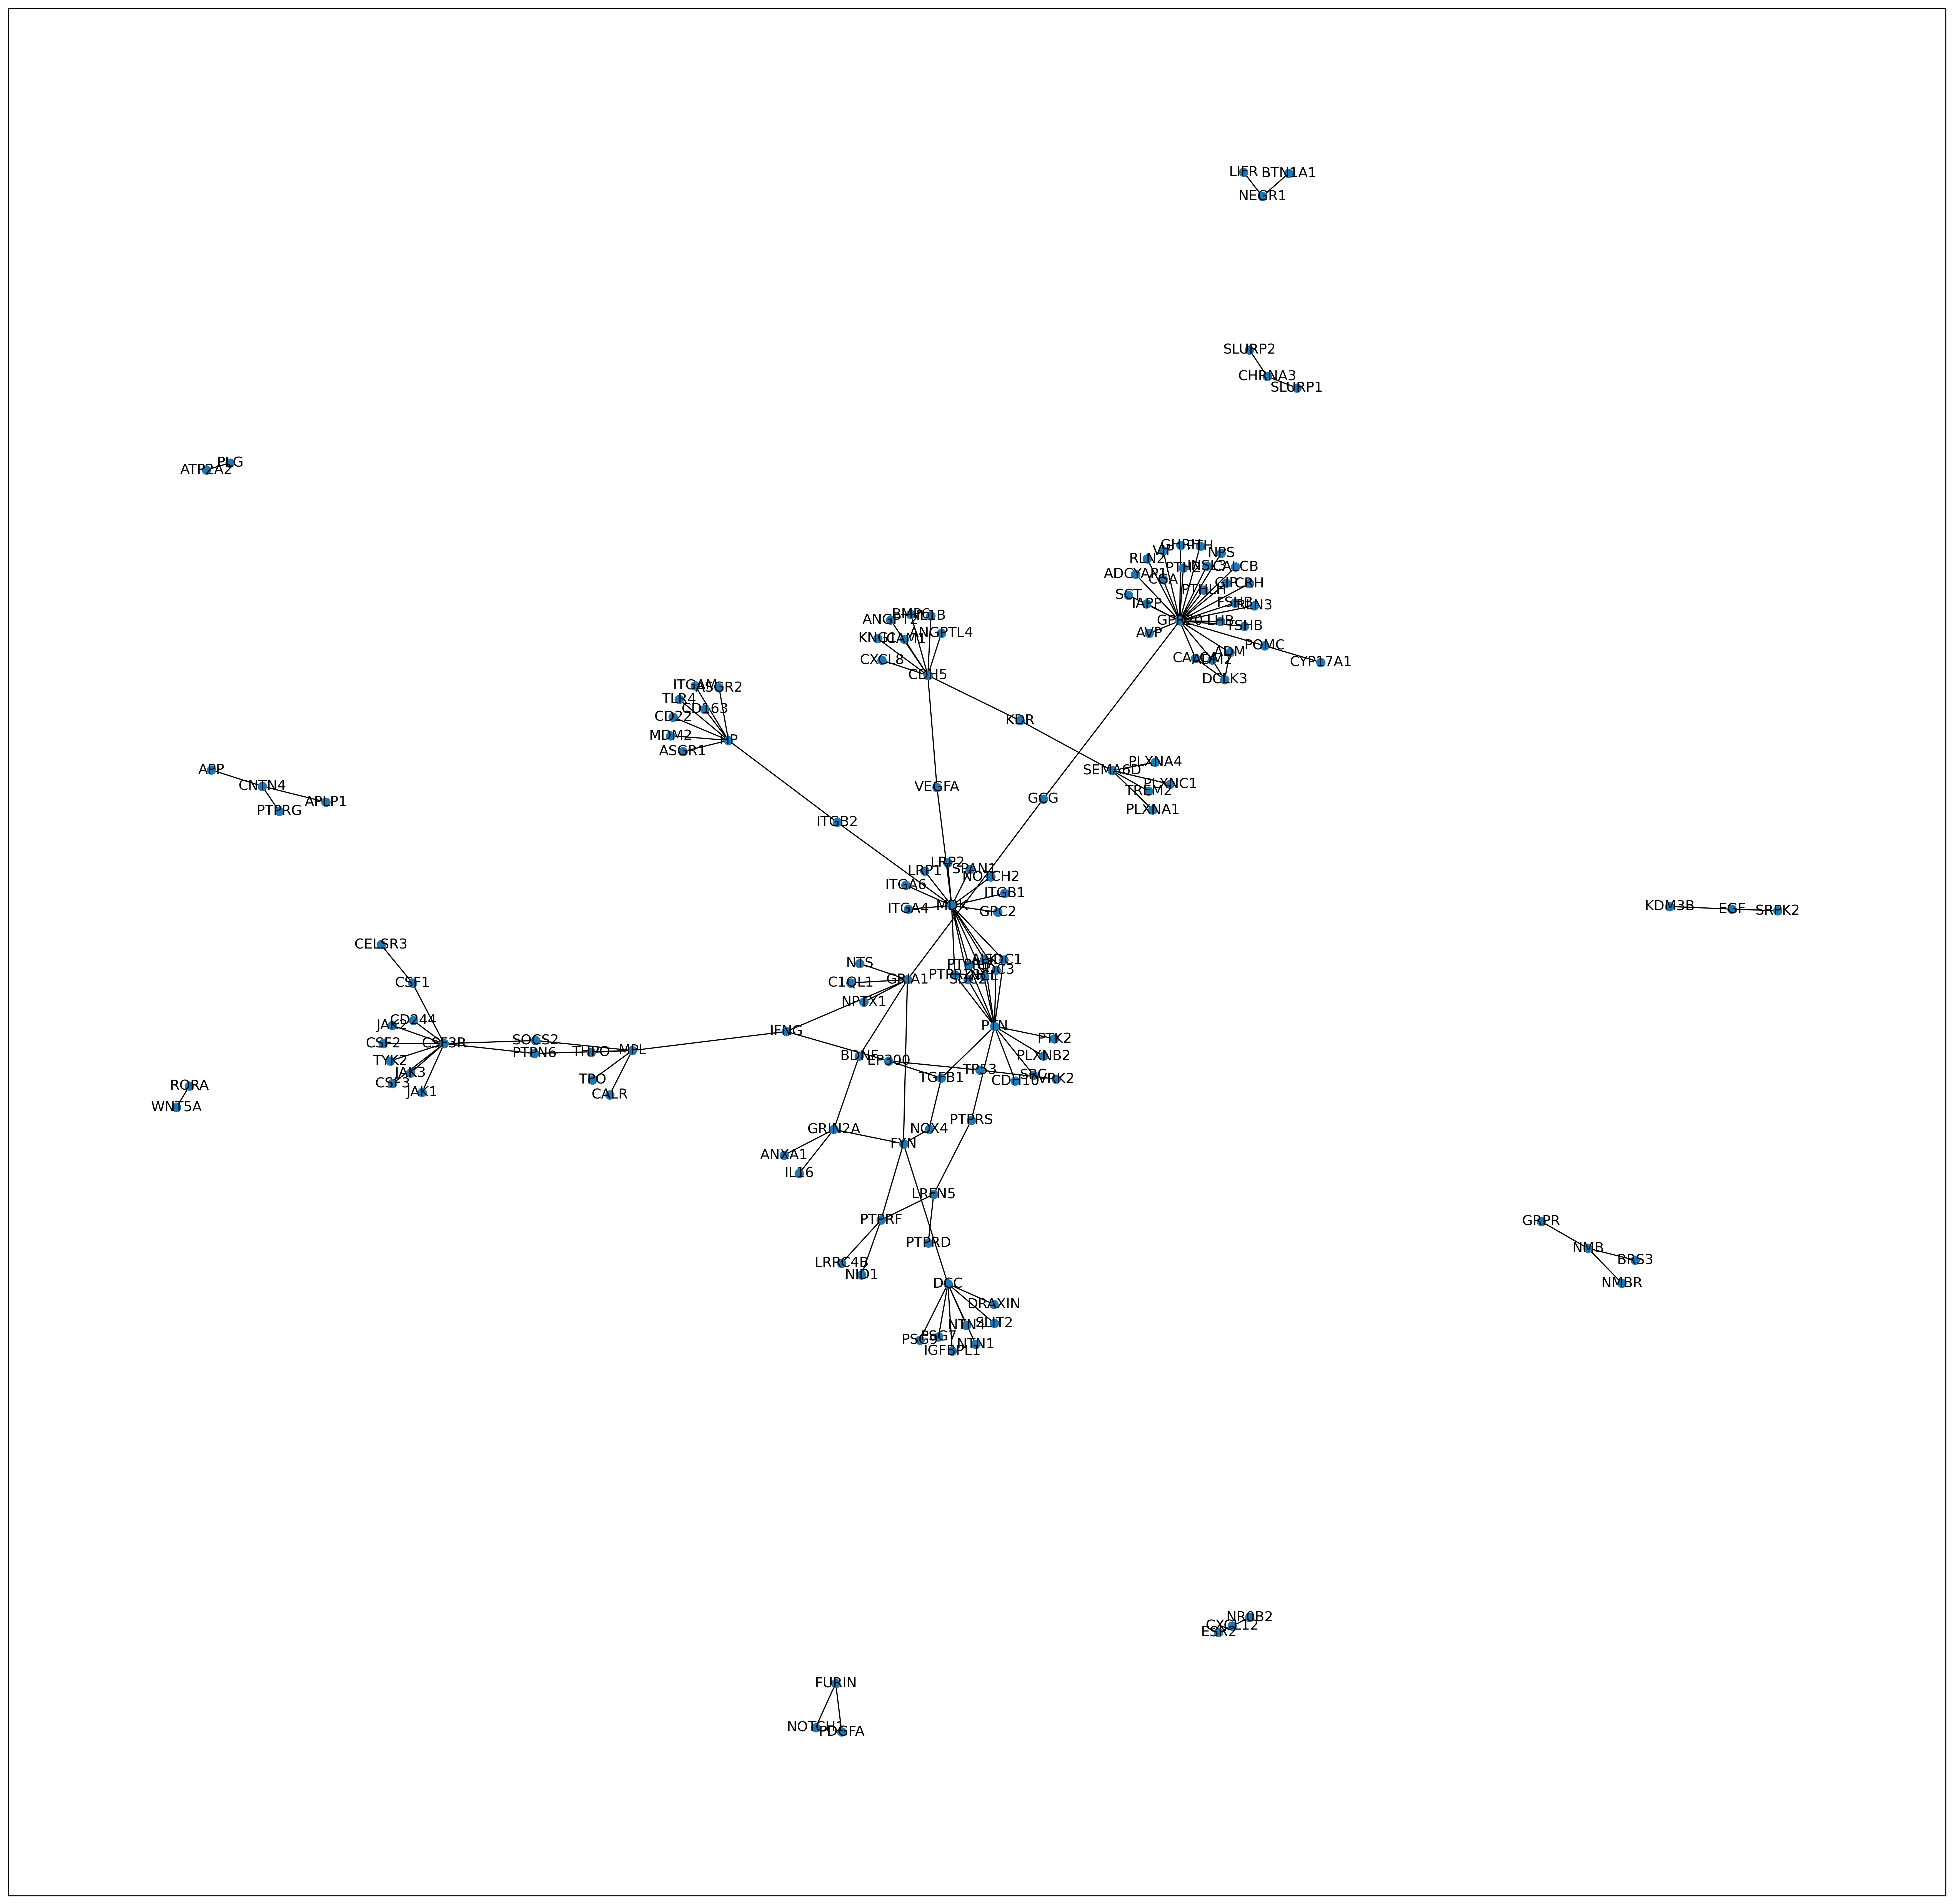

In [8]:
plt.figure(figsize=(30,30), dpi = 300)
nx.draw_networkx(G, with_labels=True, node_size = 50)

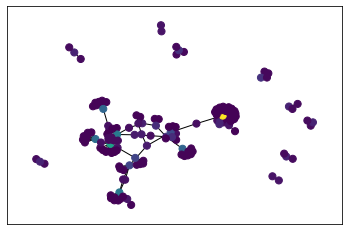

In [9]:

pgrank = pd.DataFrame.from_dict(nx.pagerank(G, alpha = 0.85, weight = 'weight'), orient = 'index')
pgrank.sort_values(by=[0], ascending = False)


colours = []
for i in G.nodes:
        if i in list(pgrank.index):
            colours.append(pgrank.loc[i][0])
        else:
            colours.append(0.0)
len(colours)

sm = nx.draw_networkx(G, node_color=colours, vmin=min(colours), vmax=max(colours), cmap=plt.get_cmap("viridis"), with_labels=False, node_size = 50)

In [10]:
cummulative_genetic_association = pd.DataFrame(unique_genes).merge(tgts[['Schizophrenia', 'BipolarDisorder', 'UnipolarDepression', 'AnorexiaNervosa', 'OCD', 'MajorDepressiveDisorder', 'TouretteSyndrome']].sum(axis = 1).to_frame().replace(np.nan,0), left_on = 0, right_index = True, how= 'left')

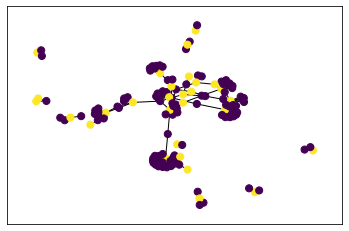

In [11]:

sm = nx.draw_networkx(G, node_color=cummulative_genetic_association.replace(np.nan,0)['0_y'], vmin=min(colours), vmax=max(colours), cmap=plt.get_cmap("viridis"), with_labels=False, node_size = 50)

In [12]:
pd.DataFrame(unique_genes)[0].to_csv('processed_data/psychiatric_network.csv', index = False)